### Finding Distribution of stock returns

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import random
from yahoo_finance_api2 import share
from yahoo_finance_api2.exceptions import YahooFinanceError
from datetime import date
import pylab
import matplotlib.pyplot as plt
import seaborn as sns

#### Getting stock Data
Using yahoo finance api to get the "SPY" stock data. 

SPY is the Exchange Traded Fund of S&P500, it mimics the S&P500 index

In [2]:
#Gets stock price of any S&P500 stock from start_date to end_date
def get_stock_prices(company_symbol, start_date, end_date):

    my_share = share.Share(company_symbol)
    symbol_data = pd.DataFrame()

    try:
        symbol_data = my_share.get_historical(share.PERIOD_TYPE_DAY,
                                              10,
                                              share.FREQUENCY_TYPE_MINUTE,
                                              60)
    except YahooFinanceError as e:
        print(e.message)
        sys.exit(1)
    stock_prices= pd.DataFrame(symbol_data)

    return stock_prices

#Returns the difference between opening and closing price of stock
def get_price_movements(stock_prices):
    price_change = stock_prices['open'] - stock_prices['close']
    
    return price_change


In [23]:

#df = pd.read_csv('Data.csv')
df=get_stock_prices('SPY', date(2018,1,1), date(2020,3,23))
df['Return'] = get_price_movements(df)
df = df.dropna()
df.tail()

,timestamp,open,high,low,close,volume,Return
102,1585036800000,232.89,233.50,231.05,232.23,0,0.66
103,1585040400000,232.22,234.00,232.00,233.90,0,-1.68
104,1585044000000,233.98,235.20,233.50,234.86,0,-0.88
105,1585047600000,234.97,235.18,231.77,232.81,0,2.16
106,1585051200000,232.77,235.09,228.03,232.18,0,0.59


#### Expectation Maximization

For this excercise lets assume that returns of the S&P500 are a distributed as mixture of Guassians. 

##### Guassian Distribution 

Guassian/Normal is a a ubiquitous probability distribution parametarized with a mean and variance. 

With probability density function of the form: 


 ### $G(X|\mu_k, \sigma_k) = $ $\frac{1}{\sigma \sqrt {2\pi }} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $
 
 By taking what is essentially the weighted average of these Guassian distributions we are able create a mixed distribution of k Guassians, represented as
 follows
 
 ### $p(X) =\sum_{k=1}^K \pi_k G(X|\mu_k, \sigma_k)$    
 
 s.t  $ \sum_{k=1}^K \pi_k = 1$
 
 The goal of the expectation maximization algorithm is to find $ \mu_k, \sigma_k, \pi_k $ that maximizes the likelihood of X. 
 The algorithm consists of two parts the Expectation step & the maximization step. In order to explain the algorithm we need to define  **$ \gamma_k = P(X|k) $**
 or the probability of X given that we know it comes from the kth cluster. 
 
 
 The algorithm goes as follows:
 
 Step 1: Intialize $ \mu_k, \sigma_k, \pi_k $ to random values. 
 
 Step 2: Compute $ \gamma_k $ for all values of k
 
 Step 3: Estimate $ \mu_k , \sigma_k, \pi_k $ using  values of $ \gamma_k $. 
 
 These estimations are done with these formula's, which are derived using the Maximum Likelihood of $P(X)$ 
 
 Formulas for restimation:
 
 #### $ \pi_k=\frac{1}{N} \sum_{n=1}^N \gamma_k(x_n) $
 ### $\mu_k=\frac{\sum_{n=1}^N \gamma_k(x_n)x_n}{\sum_{n=1}^N \gamma_k(x_n)}$
 ### $\sigma_k=\frac{\sum_{n=1}^N \gamma_k(x_n)(x_n-\mu_k)^2}{\sum{n=1}^N \gamma_k(x_n)}$
 
 where $N$ is total number of samples and $ x_n $ is the nth datapoint
 
 Step 4: Repeat until convergence.
 
 Convergence has different meaning, there can be some advanced convergence criterions but the most simplest is a fixed number of iterations. 

In [24]:
# k =number of clusters
k =3
def Initializer(k):
    #Returns a randomly initialized weights, means and standard deviation
    # intial_params contains all the intial parameters for the Guassians
    initial_params = pd.DataFrame()
    #initalizing all means to random value in df['Return']

    #initial_params['means'] = pd.Series([df['Val'].mean() for i in range(k)])
    initial_params['means'] = np.random.choice(df['Return'], k)
    #initals all stds to random values

    initial_params['std'] =np.random.random_sample(size=k)
    #intialialize all weights to be equal
    #initial_weights =[0.1,0.6,0.3]
    initial_params['weights'] = pd.Series([1/k for i in range(k)])
    
    return initial_params
initial_params = Initializer(k)
initial_params

,means,std,weights
0,5.869995,0.436010,0.333333
1,0.490000,0.907683,0.333333
2,6.494995,0.441009,0.333333


this is  0  iteration


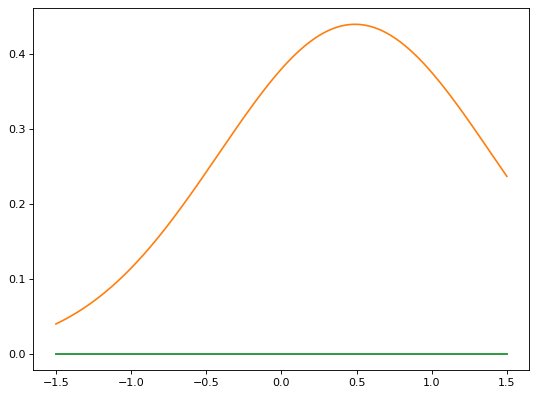

this is  50  iteration


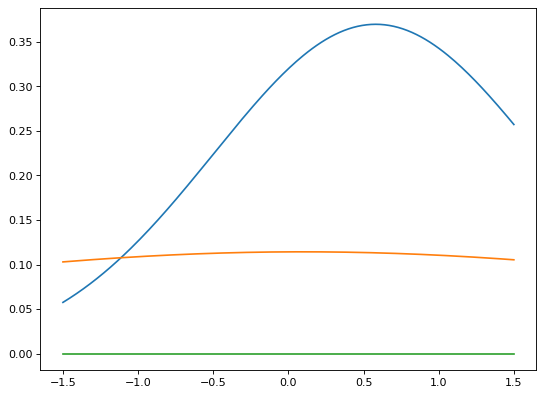

this is  100  iteration


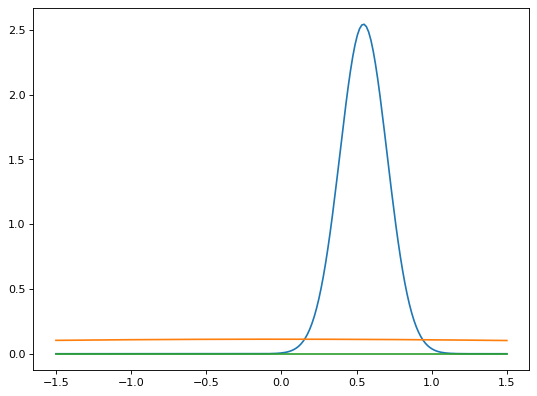

this is  150  iteration


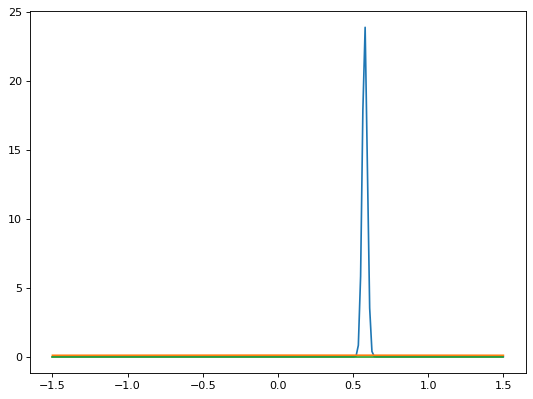

this is  200  iteration


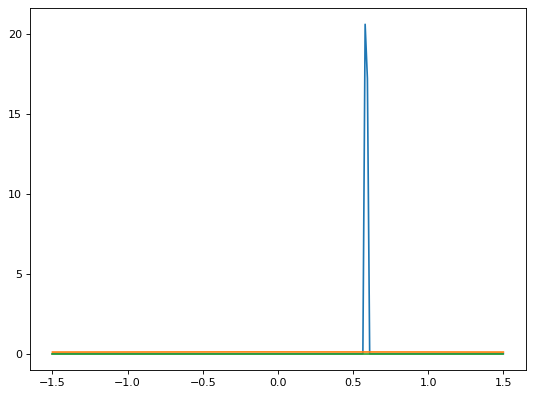

this is  250  iteration


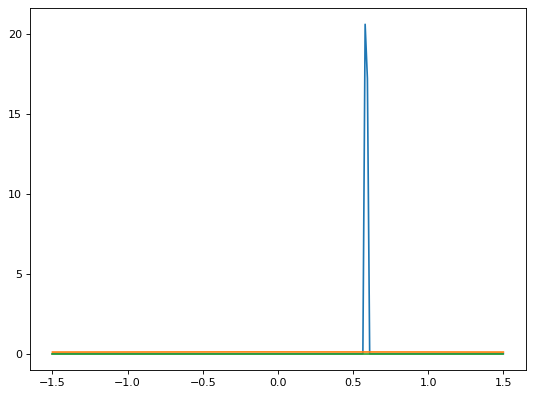

this is  300  iteration


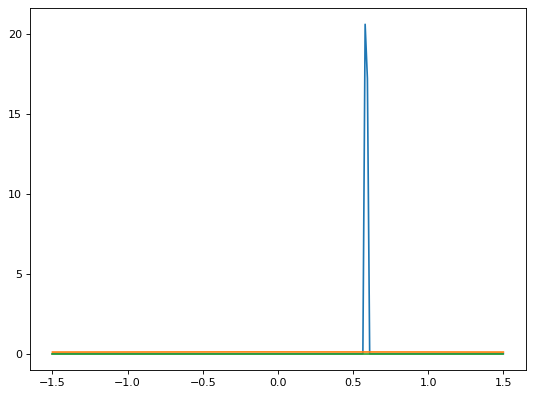

this is  350  iteration


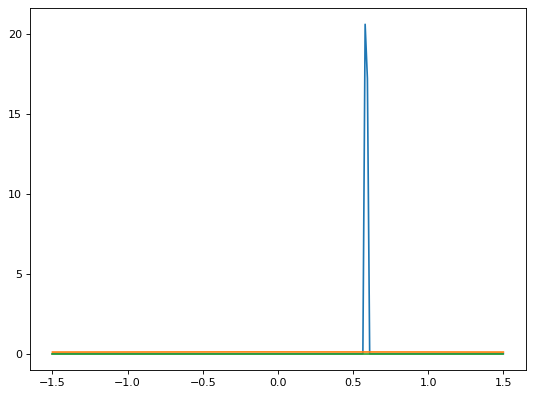

this is  400  iteration


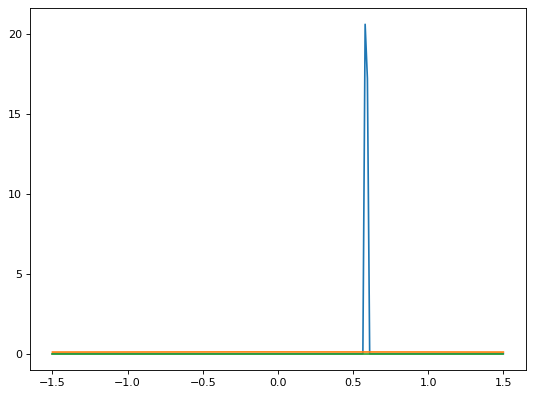

this is  450  iteration


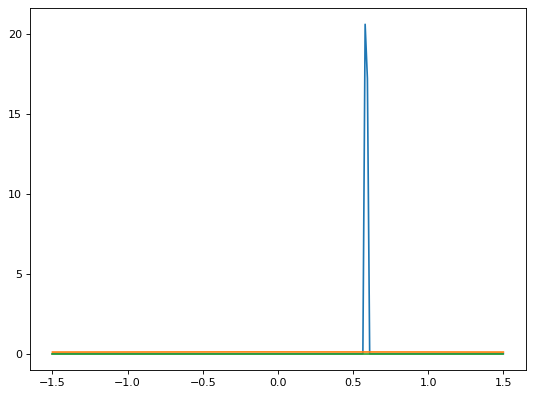

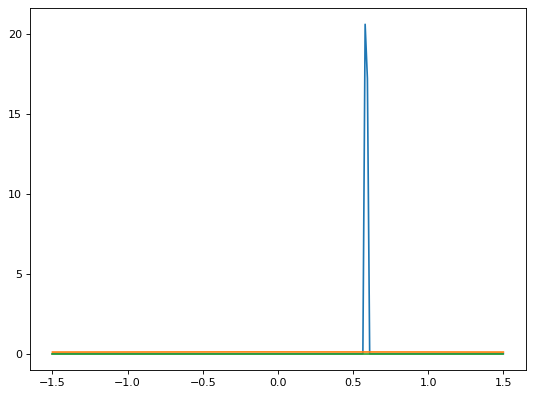

In [25]:

from scipy.stats import norm
from matplotlib.pyplot import figure

#function that plots weighted Guassians
def plot(initial_params):
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    x = np.linspace(-1.5,1.5,200)
    y = [norm.pdf(x, loc=mean, scale=sigma) for mean,sigma in zip(initial_params['means'],initial_params['std'])]   
    for Y in y:
        pylab.plot(x,Y)
    pylab.show()
def Guassian_prob(x,mean,std):
    #returns pdf of x is normally distributed
    return norm.pdf(x,mean, std)


def Expectation_Maximization(df, initial_params,k, max_iterations):
   
    for t in range(max_iterations):
        
        if(t%50==0):
            print("this is ",t," iteration")
            plot(initial_params)
        #Expectation_Step

        #name is just so that the dataframe has an appropriate name scheme
        name = 'Gamma_'
        #Gammas contains all probs
        Gammas = pd.DataFrame()
        temp_list =[]
        for i in range(k):
            #Iterate over number of Clusters
            for vals in df['Return']:
                #Iterate over all vals
                temp_list.append(initial_params['weights'][i]*Guassian_prob(vals,initial_params['means'][i],initial_params['std'][i]))
            #compute likelihoods and store in Gamma
            Gammas[name+str(i+1)] =pd.Series(temp_list)
            temp_list=[]

        #Normalizes all columns
        Gammas= Gammas.div(Gammas.sum(axis=1), axis=0)

        #Maximization Step



        pi_k = []
        mu_k = []
        std_k =[]
        #Sum=[]
        for columns in Gammas.columns:
            #total equals total values in dataset
            total =Gammas.count()[0]
            #Sum is the row wise sum of all probs
            Sum = Gammas[columns].sum(axis=0)
            #Using formula for pi_k
           
            pi_k.append(Sum/total)
            #multplying value and prob together
            temp = [val*prob for val,prob in zip(df['Return'],Gammas[columns])]
            #using formula of Means
            mu_k.append(sum(temp)/Sum)
        #display(mu_k)
        i =0
        #seperate loop for stds
        for columns in Gammas.columns:
            #temp has all deviations from mean squared multiplied by the probability of that event
            temp = [prob*(val-mu_k[i])**2 for val,prob in zip(df['Return'],Gammas[columns])]
            Sum = Gammas[columns].sum(axis=0)
            #display(sum(temp))
            #Formula for stds_k
            std_k.append(sum(temp)/Sum)
            i+=1

        initial_params['weights'] =pd.Series(pi_k)
        initial_params['means'] =pd.Series(mu_k)
        initial_params['std'] =pd.Series(np.sqrt(std_k))
        #all_params.append(initial_params)
        Gammas= pd.DataFrame()

    
        
        
    
            

        
       
        
        
    plot(initial_params)
    
    return initial_params
    
    
l = Expectation_Maximization(df,initial_params,k,500)


In [26]:
l

,means,std,weights
0,0.587730,0.004188,0.034965
1,-0.017949,3.457424,0.946819
2,6.084999,0.004997,0.018216


##### Finding the optimal value of k

This section covers how to determine the optimal value of k. There are different metrics that can be considered while evaluating which value of k we should be using. So far we have just assumed that our data is a mix of three different Guassian distributions
###### Silhouette Score

In [27]:
#compute which cluster each sample belongs to 
def predict(GMM, datapoint):
    probabilities =[]
    for means,std in zip(GMM['means'], GMM['std']):
        probabilities.append(norm.cdf(datapoint,loc=means,scale =std))
    #display(probabilities)
    return np.argmax(probabilities)
def distance(x,y):
    distances = []
    for value in y:
        distances.append(np.abs(x-value))
    
    return np.average(distances)
df['predict'] = [predict(l,x) for x in df['Return']]
display(df['predict'].value_counts())
distance = [distance(1,df[df['predict']==x]['Return']) for x in range(0,k)]
distance
#mean_distance=[np.average(df['Predict'][])]


    

1    59
0    48
Name: predict, dtype: int64

C:\Users\Arslan Shahid\Anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Arslan Shahid\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[2.0744000732421863, 3.2123747124106203, nan]